# COMP90049 Introduction to Machine Learning, 2020 Semester 2

## The University of Melbourne, School of Computing and Information Systems
-----
## Project 2: Music Genre Prediction from Audio, Metadata and Text Features!
-----
###### Student Name(s): Xulin Yang
###### Python version: 3.6.5
###### Submission deadline: 5 PM 16 October

# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import string
import re
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [2]:
RANDOM_STATE = 90049

In [3]:
def select_df1_columns_based_on_df2(df1: pd.DataFrame, df2: pd.DataFrame):
    return df1[list(df2.columns)]

# load dataset

In [4]:
def read_csv(file_path: str):
    return pd.read_csv(file_path)

In [46]:
test_features = read_csv('dataset/test_features.csv')
train_features = read_csv('dataset/train_features.csv')
train_labels = read_csv('dataset/train_labels.csv')
valid_features = read_csv('dataset/valid_features.csv')
valid_labels = read_csv('dataset/valid_labels.csv')

In [60]:
test_features = test_features.set_index('trackID')
train_features = train_features.set_index('trackID')
train_labels = train_labels.set_index('trackID')
valid_features = valid_features.set_index('trackID')
valid_labels = valid_labels.set_index('trackID')

In [7]:
valid_labels.columns

Index(['genre'], dtype='object')

In [8]:
valid_features.columns

Index(['title', 'tags', 'loudness', 'tempo', 'time_signature', 'key', 'mode',
       'duration', 'vect_1', 'vect_2',
       ...
       'vect_139', 'vect_140', 'vect_141', 'vect_142', 'vect_143', 'vect_144',
       'vect_145', 'vect_146', 'vect_147', 'vect_148'],
      dtype='object', length=156)

# Exploratory data analysis & feature engineering

In [9]:
train_merged = train_features.merge(train_labels, left_index=True, right_index=True)
train_merged.sample(2)

,title,tags,loudness,tempo,time_signature,key,mode,duration,vect_1,vect_2,...,vect_140,vect_141,vect_142,vect_143,vect_144,vect_145,vect_146,vect_147,vect_148,genre
trackID,,,,,,,,,,,,,,,,,,,,,
4445,I'll Keep Trying,"i, the, you, to, and, a, me, in, my, of, that,...",-9.356,146.873,1,10,1,147.06893,45.506589,36.343919,...,0.000148,0.000148,0.000155,0.000146,0.000129,0.000152,0.000250,0.254537,3.569970,classic pop and rock
2859,It's Over,"i, the, you, to, and, me, it, not, in, my, is,...",-5.849,196.019,4,9,1,272.22159,48.328063,46.119307,...,0.002108,0.002318,0.002446,0.002376,0.002211,0.002038,0.001807,0.218844,4.278973,soul and reggae


## Audio features & class

### select audio features

In [10]:
def select_audio_features(data: pd.DataFrame):
    tmp = pd.DataFrame()
    for i in range(1, 148+1):
        tmp["vect_" + str(i)] = data["vect_" + str(i)]
    return tmp

In [11]:
train_audio = select_audio_features(train_features)
train_audio.corr()

,vect_1,vect_2,vect_3,vect_4,vect_5,vect_6,vect_7,vect_8,vect_9,vect_10,...,vect_139,vect_140,vect_141,vect_142,vect_143,vect_144,vect_145,vect_146,vect_147,vect_148
vect_1,1.000000,0.613471,0.361311,0.143216,-0.380902,-0.459982,0.263894,0.082942,0.254093,0.323874,...,0.314225,0.319039,0.322335,0.326845,0.326263,0.314610,0.301641,0.290895,-0.201117,-0.055892
vect_2,0.613471,1.000000,0.157824,0.178521,-0.374714,-0.274621,0.193458,0.214211,0.169769,0.546503,...,0.151462,0.152527,0.162283,0.162617,0.161682,0.157039,0.141235,0.131846,-0.106270,-0.040140
vect_3,0.361311,0.157824,1.000000,0.363953,-0.145629,-0.092559,0.074088,0.204326,0.094127,0.076741,...,-0.161485,-0.161256,-0.167079,-0.164305,-0.165085,-0.162313,-0.157339,-0.159214,0.141493,0.016322
vect_4,0.143216,0.178521,0.363953,1.000000,0.009060,0.313452,0.321836,0.086015,-0.029708,0.130211,...,0.170677,0.173420,0.176283,0.178513,0.176228,0.175525,0.170650,0.163229,0.286309,0.027866
vect_5,-0.380902,-0.374714,-0.145629,0.009060,1.000000,0.212061,-0.162620,-0.045031,-0.281771,-0.300248,...,0.062352,0.061043,0.050678,0.050150,0.054917,0.059518,0.073092,0.080435,0.266447,0.063400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vect_144,0.314610,0.157039,-0.162313,0.175525,0.059518,-0.005738,0.181938,0.064768,-0.008588,0.133705,...,0.978431,0.983711,0.989278,0.990897,0.993173,1.000000,0.992284,0.983504,-0.061252,-0.015479
vect_145,0.301641,0.141235,-0.157339,0.170650,0.073092,0.007066,0.172360,0.062872,-0.013435,0.122321,...,0.976421,0.980851,0.983386,0.983387,0.985481,0.992284,1.000000,0.991064,-0.055069,-0.012652
vect_146,0.290895,0.131846,-0.159214,0.163229,0.080435,0.013692,0.159994,0.057652,-0.018299,0.110753,...,0.977044,0.976298,0.976955,0.974458,0.975088,0.983504,0.991064,1.000000,-0.059686,-0.012287
vect_147,-0.201117,-0.106270,0.141493,0.286309,0.266447,0.358942,0.015205,0.132268,-0.091160,-0.013736,...,-0.060261,-0.054083,-0.062354,-0.054693,-0.054480,-0.061252,-0.055069,-0.059686,1.000000,0.182118


In [12]:
train_audio.sample(axis=1, n=10).sort_index(axis=1).describe()

,vect_111,vect_113,vect_12,vect_13,vect_130,vect_143,vect_20,vect_25,vect_31,vect_62
count,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000
mean,0.000875,0.000828,3.360188,33.082612,0.121953,0.000816,487.077202,0.089912,0.202341,0.729012
std,0.000671,0.000655,7.515652,21.447778,0.029764,0.000724,254.769478,0.041162,0.779928,0.162772
min,0.000000,0.000000,-33.632458,0.810455,0.000000,0.000000,60.610087,0.001953,-4.369185,0.000000
25%,0.000385,0.000355,-1.461866,17.414315,0.101221,0.000317,315.162122,0.056875,-0.310300,0.621443
50%,0.000730,0.000685,3.200207,29.257318,0.119089,0.000634,441.153484,0.083631,0.178961,0.702973
75%,0.001173,0.001100,7.920112,44.053020,0.138750,0.001056,598.130550,0.119570,0.703916,0.811250
max,0.007937,0.008076,53.389272,307.168640,0.367820,0.006645,3899.359174,0.249394,3.881646,1.906904


### normalize between 0 and 1

In [13]:
def transform_continuous_0_1(data: pd.DataFrame):
    scaler = MinMaxScaler()
    scaler.fit(data)
    return pd.DataFrame(scaler.transform(data), columns=data.columns, index=data.index)

train_audio_normalized = transform_continuous_0_1(train_audio)
train_audio_normalized.describe()

,vect_1,vect_2,vect_3,vect_4,vect_5,vect_6,vect_7,vect_8,vect_9,vect_10,...,vect_139,vect_140,vect_141,vect_142,vect_143,vect_144,vect_145,vect_146,vect_147,vect_148
count,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,...,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000
mean,0.687967,0.694510,0.500421,0.364143,0.545100,0.349498,0.538276,0.595336,0.461219,0.607848,...,0.109946,0.116249,0.118736,0.122674,0.122849,0.115867,0.110817,0.105557,0.252031,0.001624
std,0.149335,0.114917,0.099743,0.091873,0.109978,0.122568,0.097141,0.065007,0.096219,0.093706,...,0.100459,0.104818,0.107537,0.109046,0.108972,0.105794,0.102149,0.098619,0.111942,0.013328
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.593106,0.623861,0.441992,0.309180,0.473877,0.263216,0.479635,0.556603,0.402614,0.544405,...,0.042628,0.045101,0.045536,0.047740,0.047705,0.044120,0.043131,0.041353,0.168768,0.000226
50%,0.702343,0.705498,0.505595,0.358934,0.551838,0.340809,0.540254,0.596846,0.461027,0.607984,...,0.085561,0.089974,0.091221,0.095181,0.095410,0.088682,0.084195,0.080066,0.233756,0.000493
75%,0.801927,0.775508,0.562843,0.412623,0.618362,0.421001,0.600751,0.635181,0.522757,0.674452,...,0.140107,0.149403,0.152993,0.158037,0.158916,0.148148,0.140473,0.132388,0.318338,0.001157
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### drop highly correlated, >=0.3

In [14]:
def drop_highly_correlated(data: pd.DataFrame, threshold=0.3):
    # Create correlation matrix
    corr_matrix = data.corr().abs()

    remained = [corr_matrix.columns[0]]
    for column in corr_matrix.columns[1:]:
        to_select = True
        for c in remained:
            if corr_matrix[column][c] >= threshold:
                to_select = False
        if to_select:
            remained.append(column)

    return data[remained]

train_audio_normalized_low_corr = drop_highly_correlated(train_audio_normalized)

valid_audio_normalized_low_corr = select_df1_columns_based_on_df2(valid_features, train_audio_normalized_low_corr)
valid_audio_normalized_low_corr = transform_continuous_0_1(valid_audio_normalized_low_corr)
train_audio_normalized_low_corr.corr()

,vect_1,vect_4,vect_8,vect_9,vect_11,vect_12,vect_28,vect_32,vect_35,vect_36,vect_37,vect_38,vect_39,vect_41,vect_55,vect_58,vect_88,vect_91
vect_1,1.000000,0.143216,0.082942,0.254093,0.153325,-0.167586,-0.135888,-0.125213,0.041237,0.123246,0.020191,0.249180,0.176923,0.036430,-0.037805,0.062877,-0.102857,-0.171568
vect_4,0.143216,1.000000,0.086015,-0.029708,0.293636,-0.185825,0.180864,-0.270113,-0.143982,-0.057346,-0.004109,-0.038031,0.006549,0.016927,0.011349,0.265278,0.089628,-0.049630
vect_8,0.082942,0.086015,1.000000,-0.122371,-0.251873,-0.095729,-0.129706,-0.158684,0.026654,0.001975,0.092607,0.118402,0.116893,0.034822,0.023075,0.099649,0.096239,0.069155
vect_9,0.254093,-0.029708,-0.122371,1.000000,-0.019650,0.089415,-0.039546,0.014363,-0.068363,0.178397,0.015619,0.205017,0.119039,0.010816,-0.005052,-0.024627,-0.076337,-0.089513
vect_11,0.153325,0.293636,-0.251873,-0.019650,1.000000,0.213998,0.021981,0.017849,-0.047907,0.013849,-0.157042,-0.080726,-0.174763,-0.152472,-0.008913,-0.141883,-0.094346,-0.110107
vect_12,-0.167586,-0.185825,-0.095729,0.089415,0.213998,1.000000,-0.005021,0.007400,0.056239,0.069425,-0.128340,-0.079521,-0.167215,-0.133916,0.005443,-0.166333,0.001394,0.019017
vect_28,-0.135888,0.180864,-0.129706,-0.039546,0.021981,-0.005021,1.000000,-0.059309,0.004506,-0.051670,0.043093,-0.123882,-0.024224,0.061039,-0.008465,0.272766,-0.166053,-0.130244
vect_32,-0.125213,-0.270113,-0.158684,0.014363,0.017849,0.007400,-0.059309,1.000000,0.132702,0.108337,-0.034128,0.053074,0.016505,-0.019420,-0.054762,-0.153974,-0.031807,0.020478
vect_35,0.041237,-0.143982,0.026654,-0.068363,-0.047907,0.056239,0.004506,0.132702,1.000000,0.112221,0.152352,0.142193,0.101443,0.042486,-0.102722,0.145389,0.018223,-0.019153
vect_36,0.123246,-0.057346,0.001975,0.178397,0.013849,0.069425,-0.051670,0.108337,0.112221,1.000000,0.046396,0.289810,0.030438,-0.012414,-0.064258,0.048125,-0.012550,0.020607


### select k best (half), chi

In [15]:
k = int(len(train_audio_normalized_low_corr.columns) / 2)

selector = SelectKBest(chi2, k=k)
selector.fit_transform(train_audio_normalized_low_corr, train_labels)
train_audio_normalized_low_corr_chi_selected = train_audio_normalized_low_corr[train_audio_normalized_low_corr.columns[selector.get_support()]]
valid_audio_normalized_low_corr_chi_selected = select_df1_columns_based_on_df2(valid_features, train_audio_normalized_low_corr_chi_selected)
valid_audio_normalized_low_corr_chi_selected = transform_continuous_0_1(valid_audio_normalized_low_corr_chi_selected)
train_audio_normalized_low_corr_chi_selected.describe()

,vect_1,vect_4,vect_8,vect_9,vect_11,vect_36,vect_38,vect_39,vect_58
count,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000
mean,0.687967,0.364143,0.595336,0.461219,0.474519,0.527084,0.564262,0.561863,0.255684
std,0.149335,0.091873,0.065007,0.096219,0.077009,0.099709,0.090358,0.083403,0.148599
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.593106,0.309180,0.556603,0.402614,0.431284,0.465790,0.507228,0.513358,0.156278
50%,0.702343,0.358934,0.596846,0.461027,0.477054,0.528301,0.564528,0.563551,0.220584
75%,0.801927,0.412623,0.635181,0.522757,0.519129,0.588691,0.622121,0.612966,0.310626
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
train_audio_normalized_low_corr_chi_selected.corr()

,vect_1,vect_4,vect_8,vect_9,vect_11,vect_36,vect_38,vect_39,vect_58
vect_1,1.000000,0.143216,0.082942,0.254093,0.153325,0.123246,0.249180,0.176923,0.062877
vect_4,0.143216,1.000000,0.086015,-0.029708,0.293636,-0.057346,-0.038031,0.006549,0.265278
vect_8,0.082942,0.086015,1.000000,-0.122371,-0.251873,0.001975,0.118402,0.116893,0.099649
vect_9,0.254093,-0.029708,-0.122371,1.000000,-0.019650,0.178397,0.205017,0.119039,-0.024627
vect_11,0.153325,0.293636,-0.251873,-0.019650,1.000000,0.013849,-0.080726,-0.174763,-0.141883
vect_36,0.123246,-0.057346,0.001975,0.178397,0.013849,1.000000,0.289810,0.030438,0.048125
vect_38,0.249180,-0.038031,0.118402,0.205017,-0.080726,0.289810,1.000000,0.237216,0.022988
vect_39,0.176923,0.006549,0.116893,0.119039,-0.174763,0.030438,0.237216,1.000000,0.102894
vect_58,0.062877,0.265278,0.099649,-0.024627,-0.141883,0.048125,0.022988,0.102894,1.000000


## label distribution

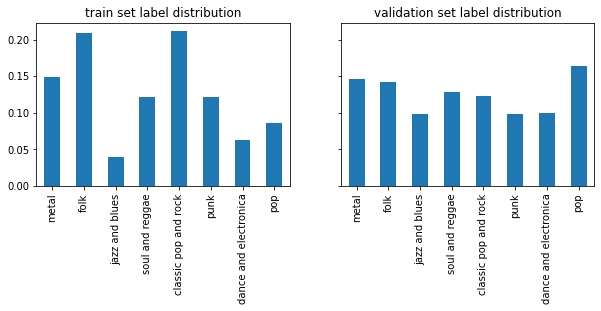

In [17]:
def draw_train_valid_label_distribution(train_labels: pd.DataFrame, valid_labels: pd.DataFrame, 
                                        title1='train set label distribution',
                                        title2='validation set label distribution'):
    xs = train_labels["genre"].unique()

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,3))
    ax1.set_title(title1)
    (train_labels["genre"].value_counts() / sum(train_labels["genre"].value_counts().sort_index()))[xs].plot(ax=ax1, kind='bar')

    ax2.set_title(title2)
    (valid_labels["genre"].value_counts() / sum(valid_labels["genre"].value_counts().sort_index()))[xs].plot(ax=ax2, kind='bar')
    plt.show()

draw_train_valid_label_distribution(train_labels, valid_labels)

## random forest select features

In [18]:
def select_meta_data_features(data: pd.DataFrame):
    tmp = data.copy()
    tmp = tmp[["loudness", "tempo", "time_signature", "key", "mode", "duration"]]
    return tmp

In [19]:
def one_hot_encoding(data: pd.DataFrame, column_name):
    new_df = data.copy()
    new_df = pd.get_dummies(new_df, prefix=column_name, columns=[column_name])
    
    return new_df

In [20]:
train_meta = one_hot_encoding(select_meta_data_features(train_features), "key")
train_audio = select_audio_features(train_features)

train_continuous_meta_audio = pd.concat([train_meta, train_audio], axis=1)
train_continuous_0_1_meta_audio = transform_continuous_0_1(train_continuous_meta_audio)
train_continuous_0_1_meta_audio.describe()

,loudness,tempo,time_signature,mode,duration,key_0,key_1,key_2,key_3,key_4,...,vect_139,vect_140,vect_141,vect_142,vect_143,vect_144,vect_145,vect_146,vect_147,vect_148
count,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,...,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000,7678.000000
mean,0.742859,0.497992,0.509936,0.684032,0.184862,0.130633,0.076713,0.118911,0.029174,0.088174,...,0.109946,0.116249,0.118736,0.122674,0.122849,0.115867,0.110817,0.105557,0.252031,0.001624
std,0.124869,0.137136,0.171021,0.464930,0.069662,0.337020,0.266152,0.323705,0.168306,0.283566,...,0.100459,0.104818,0.107537,0.109046,0.108972,0.105794,0.102149,0.098619,0.111942,0.013328
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.667110,0.395195,0.428571,0.000000,0.144015,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.042628,0.045101,0.045536,0.047740,0.047705,0.044120,0.043131,0.041353,0.168768,0.000226
50%,0.766298,0.481870,0.571429,1.000000,0.176894,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.085561,0.089974,0.091221,0.095181,0.095410,0.088682,0.084195,0.080066,0.233756,0.000493
75%,0.838943,0.581165,0.571429,1.000000,0.214027,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.140107,0.149403,0.152993,0.158037,0.158916,0.148148,0.140473,0.132388,0.318338,0.001157
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
TOP_N_FEATURES = 10

sel = SelectFromModel(RandomForestClassifier(n_estimators = 1000, 
                                             random_state=RANDOM_STATE, 
                                             criterion="entropy",
                                             max_depth=TOP_N_FEATURES))
sel.fit(train_continuous_0_1_meta_audio, train_labels.values.ravel())
sel.get_support()

array([ True, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False,  True,  True,  True, False,  True, False,  True,
        True, False, False,  True,  True,  True, False,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
        True, False, False, False,  True, False, False,  True, False,
        True,  True,  True, False, False, False, False, False, False,
       False, False,

In [23]:
selected_feat= train_continuous_0_1_meta_audio.columns[(sel.get_support())]
selected_feat

Index(['loudness', 'duration', 'vect_1', 'vect_2', 'vect_4', 'vect_5',
       'vect_6', 'vect_8', 'vect_10', 'vect_11', 'vect_14', 'vect_15',
       'vect_16', 'vect_18', 'vect_19', 'vect_20', 'vect_22', 'vect_23',
       'vect_24', 'vect_25', 'vect_26', 'vect_27', 'vect_29', 'vect_30',
       'vect_54', 'vect_55', 'vect_56', 'vect_57', 'vect_58', 'vect_60',
       'vect_61', 'vect_62', 'vect_63', 'vect_65', 'vect_85', 'vect_86',
       'vect_92', 'vect_96', 'vect_99', 'vect_101', 'vect_102', 'vect_103',
       'vect_120', 'vect_123', 'vect_128', 'vect_133', 'vect_134'],
      dtype='object')

In [24]:
train_random_forest_selected = train_continuous_0_1_meta_audio[selected_feat]
# train_random_forest_selected.corr()
valid_random_forest_selected = select_df1_columns_based_on_df2(valid_features, train_random_forest_selected)
valid_random_forest_selected = transform_continuous_0_1(valid_random_forest_selected)

In [25]:
# train_random_forest_selected_independent = drop_highly_correlated(train_random_forest_selected, threshold=0.3)
# train_random_forest_selected_independent.corr()

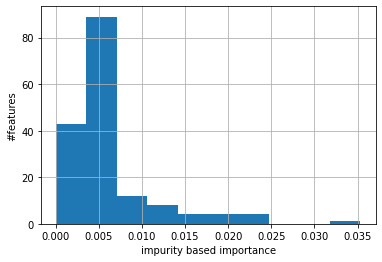

In [26]:
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()
plt.xlabel("impurity based importance")
plt.ylabel("#features")
plt.show()

# train test evaluate functions

## train

In [27]:
def train(models: list, X: pd.DataFrame, Y: pd.DataFrame):
    trained = []
    for m in models:
        m.fit(X, Y.values.ravel())
        trained.append(m)
    return trained

## predict

In [28]:
def predict(models: list, X: pd.DataFrame):
    y_preds = []
    for m in models:
        preds = m.predict(X)
        y_preds.append(pd.DataFrame(preds, columns=["genre"], index=X.index))
    return y_preds

## evaluate

In [29]:
# This function should evaluate a set of predictions in terms of metrics
def evaluate(pred, true, average='macro'):
    CM = metrics.confusion_matrix(true, pred) # Confusion Matrix
    Acc = metrics.accuracy_score(true, pred) # Accuracy
#     'micro':
#         Calculate metrics globally by counting the total true positives, false 
#         negatives and false positives.

#     'macro':
#         Calculate metrics for each label, and find their unweighted mean. This 
#         does not take label imbalance into account.

#     'weighted':
#         Calculate metrics for each label, and find their average weighted by 
#         support (the number of true instances for each label). This alters 
#         ‘macro’ to account for label imbalance; it can result in an F-score that 
#         is not between precision and recall.
#   
#   As we have imbalanced class distribution, we use macro
    precf1 = metrics.precision_recall_fscore_support(true, pred, average=average, zero_division=0) # Precision, Recall and F1-score
    return CM, Acc, precf1

# knn

## choose best k for chi2 half, only audio

As mentioned in the slide, for weighted k-nn, we have three strategies: Majority voting, Inverse Linear Distance and Inverse Distance. 

Majority is not considering the case when there are neighbors really similar to the test instance but belong to the minority. That is why you need approaches that consider this, namely, inverse distance and inverse linear distance. As we have imbalanced class distribution in the dataset. So majority method is not considered. 
Within the context of k-nn, I wouldn’t choose a winner between inverse distance and inverse linear distance. Both methods achieve the same, roughly. The only difference I can emphasize has to do with the set of possible values. The inverse linear distance is bounded to be within 0 and 1. As sklearn.neighbors.KNeighborsClassifier only supports builtin:
- ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
- ‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

So I will just consider inverse distance weighting method.

As all attributes are normalized between 0 and 1, Euclidean and Manhattan distance is no longer affected by attribute magnitude. Otherwise, the distance will be dominated by avg_glucose_level, bmi, age attributes as they originally has large magnitude than other 0-1 based attribute. 

So for three distance Euclidean, Manhattan and Cosine. Cosine distance is not a proper distance metric as it fails the triangle inequality. What's more, it takes more time to compute than Euclidean and Manhattan. As the normalization makes Euclidean and Manhattan not be sensitive to magnitude just as Cosine. So I will just consider Euclidean and Manhattan for Knn classifier.

In [ ]:
# k_max = train_audio_normalized_low_corr_chi_selected.shape[0] - 1 # all

def select_best_k(X_train: pd.DataFrame, Y_train: pd.DataFrame, X_valid: pd.DataFrame, Y_valid: pd.DataFrame, k_max=500):
    ks = []
    f1s = [[], []]

    for k in range(1, k_max):
        models = [KNeighborsClassifier(n_neighbors=k, weights="distance", metric='euclidean'), 
                  KNeighborsClassifier(n_neighbors=k, weights="distance", metric='manhattan')]
        trained_models = train(models, train_audio_normalized_low_corr_chi_selected, train_labels)
        model_preds = predict(trained_models, valid_audio_normalized_low_corr_chi_selected)
        for i, preds in enumerate(model_preds):
            _, _, pref = evaluate(preds, valid_labels)
            f1s[i].append(pref[2])
        ks.append(k)

        print(k, k_max)
    return ks, f1s

In [ ]:
ks, f1s = select_best_k(train_audio_normalized_low_corr_chi_selected, 
                        train_labels, 
                        valid_audio_normalized_low_corr_chi_selected, 
                        valid_labels, 
                        k_max=200)

In [ ]:
def draw_k_line_chart(x, y, ylabel, title):
    plt.figure(figsize=(10, 3))
    plt.plot(x, y, 'b-')
    plt.xlabel("k")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [ ]:
draw_k_line_chart(ks, f1s[0], "f1 score", "knn euclidean")
knn_euclidean_k = ks[np.argmax(f1s[0])]
print("k maximize f1-score :", knn_euclidean_k, "with", f1s[0][np.argmax(f1s[0])])

In [ ]:
draw_k_line_chart(ks, f1s[1], "f1 score", "knn manhattan")
knn_manhattan_k = ks[np.argmax(f1s[1])]
print("k maximize f1-score :", knn_manhattan_k, "with", f1s[1][np.argmax(f1s[1])])

In [ ]:
trained_knn = KNeighborsClassifier(n_neighbors=knn_manhattan_k, weights="distance", metric='manhattan')
trained_knn.fit(train_audio_normalized_low_corr_chi_selected, train_labels.values.ravel())

In [ ]:
preds = trained_knn.predict(valid_audio_normalized_low_corr_chi_selected)
# CM, _, prefs = evaluate(preds, valid_labels, average=None)
print(classification_report(valid_labels, preds, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(preds, columns=valid_labels.columns, index=valid_audio_normalized_low_corr_chi_selected.index), 
                                    valid_labels,
                                    title1="knn manhattan k=123 validation set prediction")
draw_train_valid_label_distribution(pd.DataFrame(preds, columns=valid_labels.columns, index=valid_audio_normalized_low_corr_chi_selected.index), 
                                    train_labels,
                                    title1="knn manhattan k=123 validation set prediction",
                                    title2="train set label distribution")

## choose best k for no chi2 half, only audio

In [ ]:
ks, f1s, = select_best_k(train_audio_normalized_low_corr, 
                        train_labels, 
                        valid_audio_normalized_low_corr, 
                        valid_labels, 
                        k_max=200)

In [ ]:
draw_k_line_chart(ks, f1s[0], "f1 score", "knn euclidean")
knn_euclidean_k = ks[np.argmax(f1s[0])]
print("k maximize f1-score :", knn_euclidean_k, "with", f1s[0][np.argmax(f1s[0])])

In [ ]:
draw_k_line_chart(ks, f1s[1], "f1 score", "knn manhattan")
knn_manhattan_k = ks[np.argmax(f1s[1])]
print("k maximize f1-score :", knn_manhattan_k, "with", f1s[1][np.argmax(f1s[1])])

## random forest selected features

In [ ]:
ks, f1s, = select_best_k(train_random_forest_selected, 
                        train_labels, 
                        valid_random_forest_selected, 
                        valid_labels, 
                        k_max=200)

In [ ]:
draw_k_line_chart(ks, f1s[0], "f1 score", "knn euclidean")
knn_euclidean_k = ks[np.argmax(f1s[0])]
print("k maximize f1-score :", knn_euclidean_k, "with", f1s[0][np.argmax(f1s[0])])

In [ ]:
draw_k_line_chart(ks, f1s[1], "f1 score", "knn manhattan")
knn_manhattan_k = ks[np.argmax(f1s[1])]
print("k maximize f1-score :", knn_manhattan_k, "with", f1s[1][np.argmax(f1s[1])])

In [ ]:
trained_knn = KNeighborsClassifier(n_neighbors=knn_manhattan_k, weights="distance", metric='manhattan')
trained_knn.fit(train_random_forest_selected, train_labels.values.ravel())

preds = trained_knn.predict(valid_random_forest_selected)
# CM, _, prefs = evaluate(preds, valid_labels, average=None)
print(classification_report(valid_labels, preds, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(preds, columns=valid_labels.columns, index=valid_random_forest_selected.index), 
                                    valid_labels,
                                    title1="knn manhattan k=123 validation set prediction")
draw_train_valid_label_distribution(pd.DataFrame(preds, columns=valid_labels.columns, index=valid_random_forest_selected.index), 
                                    train_labels,
                                    title1="knn manhattan k=123 validation set prediction",
                                    title2="train set label distribution")

### test

In [ ]:
models = [trained_knn]
test_knn = select_df1_columns_based_on_df2(test_features, train_random_forest_selected)
test_knn = transform_continuous_0_1(test_knn)
test_preds = predict(models, test_knn)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

# Naive Bayes

In [30]:
def gaussian_pdf(x, mean_xs_by_y, std_xs_by_y, c, i):
    return (1 / (math.sqrt(2 * math.pi) * std_xs_by_y[c][i])) * \
            math.exp(-((x[i] - mean_xs_by_y[c][i]) ** 2 / (2 * std_xs_by_y[c][i] ** 2)))

In [31]:
from sklearn.naive_bayes import GaussianNB
def gnb_train_predict(train_x, train_y, validation_x, validation_y):
    clf = GaussianNB()
    clf.fit(train_x, train_y)
#     print("Gaussian NB",clf.score(validation_x,validation_y))
#     print("Gaussian NB",clf)
    
    return clf.predict(validation_x)

In [32]:
train_features_random_forest_selected = train_features[selected_feat]
valid_features_random_forest_selected = valid_features[selected_feat]
preds = gnb_train_predict(train_features_random_forest_selected, train_labels, valid_features_random_forest_selected, valid_labels)


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


                       precision    recall  f1-score   support

      soul and reggae       0.24      0.36      0.29        55
 classic pop and rock       0.50      0.24      0.33        45
                metal       0.34      0.42      0.38        64
                 folk       0.32      0.20      0.25        44
                  pop       0.75      0.77      0.76        66
dance and electronica       0.48      0.43      0.46        74
       jazz and blues       0.51      0.43      0.47        44
                 punk       0.60      0.67      0.63        58

             accuracy                           0.46       450
            macro avg       0.47      0.44      0.45       450
         weighted avg       0.48      0.46      0.46       450



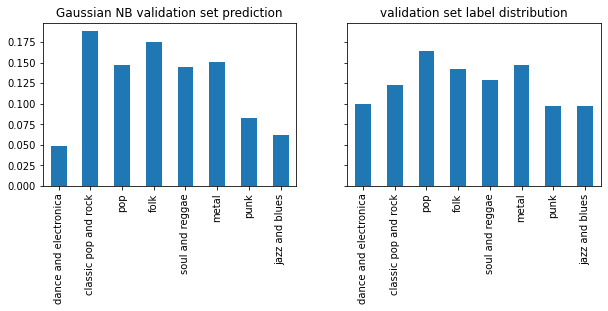

In [33]:
print(classification_report(valid_labels, preds, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(preds, columns=valid_labels.columns, index=valid_audio_normalized_low_corr_chi_selected.index), 
                                    valid_labels,
                                    title1="Gaussian NB validation set prediction")

In [138]:
train_features_num = train_features._get_numeric_data()
valid_features_num = valid_features._get_numeric_data()
test_features_num = _features._get_numeric_data()
train_features_num


,loudness,tempo,time_signature,key,mode,duration,vect_1,vect_2,vect_3,vect_4,...,vect_139,vect_140,vect_141,vect_142,vect_143,vect_144,vect_145,vect_146,vect_147,vect_148
trackID,,,,,,,,,,,,,,,,,,,,,
8424,-2.824,131.969,4,0,1,298.13506,52.050795,55.591771,20.057026,-0.274684,...,0.001097,0.001161,0.001225,0.001251,0.001238,0.001202,0.001130,0.001040,0.104525,0.335818
7923,-11.249,136.510,4,4,1,248.03220,38.488583,-38.186087,-5.917110,-12.937670,...,0.000117,0.000134,0.000147,0.000161,0.000157,0.000126,0.000121,0.000134,0.124080,1.553742
2314,-6.932,72.878,4,7,1,231.00036,45.424130,36.587988,24.220092,-5.630071,...,0.000962,0.001203,0.001214,0.001152,0.001025,0.000933,0.000838,0.000867,0.311885,7.835358
810,-12.551,75.381,3,6,1,390.29506,42.546616,47.126411,23.625371,-7.261937,...,0.000167,0.000183,0.000198,0.000205,0.000203,0.000197,0.000183,0.000164,0.115680,0.395675
439,-14.566,134.331,4,5,0,286.11873,36.161980,-6.806859,14.974707,-4.010917,...,0.000084,0.000089,0.000094,0.000100,0.000098,0.000089,0.000083,0.000078,0.186119,1.472794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6419,-10.798,146.624,1,7,1,236.48608,40.258501,-52.111872,19.853431,21.129912,...,0.001282,0.001359,0.001422,0.001447,0.001430,0.001438,0.001437,0.001474,0.184104,2.765411
6811,-3.759,153.760,4,6,1,171.78077,51.767393,68.259900,0.104259,-7.568613,...,0.000588,0.000628,0.000633,0.000659,0.000643,0.000619,0.000562,0.000526,0.075420,0.216842
1474,-11.883,98.596,4,10,1,255.58159,40.285352,12.846995,18.955819,-4.602336,...,0.000163,0.000159,0.000164,0.000173,0.000172,0.000164,0.000154,0.000163,0.169215,1.786019


In [35]:
clf = GaussianNB()
gclf = clf.fit(train_features_num, train_labels)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [36]:
models = [gclf]
test_knn = select_df1_columns_based_on_df2(test_features, train_features_random_forest_selected)
test_preds = predict(models, test_knn)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

# Texts

In [150]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

In [151]:
train_features_text = train_features[['title', 'tags']]
train_features_text

,title,tags
trackID,,
8424,The Calamity [Explicit],"the, you, to, a, not, in, of, that, are, we, w..."
7923,Try To Find Me,"i, the, you, to, and, a, me, it, not, in, my, ..."
2314,Poor Old Dirt Farmer,"the, to, and, a, in, is, on, all, no, have, bu..."
810,Texas Flood,"i, the, you, to, and, a, me, it, not, in, my, ..."
439,Chopsticks Medley,"i, to, and, me, love, but, with, oh, they, she..."
...,...,...
6419,Stop That Train,"i, the, to, and, a, it, not, my, that, do, am,..."
6811,In A Close Encounter,"i, the, to, a, in, my, of, so, with, they, see..."
1474,Our Lady Of Sorrow (LP Version),"i, the, you, to, and, a, not, in, is, of, that..."


In [152]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [153]:
def clean_tag(allTags):
    newTags = []
    for eachTag in allTags:
        eachTag = remove_punctuations(eachTag)
        newTags.append(eachTag)

    return np.array(newTags) 

In [154]:
def clean_title(allTitles):
    newTitles = []
    for eachTitle in allTitles:
        trantab = str.maketrans({key: None for key in string.punctuation})
        eachTitle = eachTitle.translate(trantab)
        eachTitle = re.sub('\d+','',eachTitle)
        newTitles.append(eachTitle)
#     print(newTitles)
    
    return np.array(newTitles) 

In [155]:
def computeTFIDF(trainCorpus,corpus,note):
    if(note == 'tag'):
        corpus = clean_tag(corpus)
        trainCorpus = clean_tag(trainCorpus)
    if(note == 'title'):
        corpus = clean_title(corpus)
        trainCorpus = clean_title(trainCorpus)
    
    # convert text to TF matrix
    # ！！！set the min length of word from the default >=2 to >=1
    vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
    
    # calculate how many times for each word
    # do the dfidf
    tfidf = vectorizer.fit(trainCorpus)
    vectors = tfidf.transform(corpus)
    # get all words
    word = vectorizer.get_feature_names()
    dense = vectors.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns = word)

    return df

In [156]:
def scale_data(X_train, X):
    # scale to [0,1]
    header = X_train.columns
    min_max_scaler = preprocessing.MinMaxScaler()
    X_train = min_max_scaler.fit(X_train)
    X = min_max_scaler.transform(X)
    X = pd.DataFrame(X, columns=header)
    
    return X 

In [157]:
# tag: haven't tfidf
tag_for_train = (train_features.iloc[:,1]).values
tag_for_valid = (valid_features.iloc[:,1]).values
tag_for_test = (test_features.iloc[:,1]).values

# title: haven't tfidf
title_for_train = (train_features.iloc[:,0]).values
title_for_valid = (valid_features.iloc[:,0]).values
title_for_test = (test_features.iloc[:,0]).values

# title: tfidf
train_title = computeTFIDF(title_for_train,title_for_train,'title').set_index(train_features.index)
valid_title = computeTFIDF(title_for_train,title_for_valid,'title').set_index(valid_features.index)
test_title = computeTFIDF(title_for_train,title_for_test,'title').set_index(test_features.index)


# tag: tfidf
train_tag = computeTFIDF(tag_for_train,tag_for_train,'tag').set_index(train_features.index)
valid_tag = computeTFIDF(tag_for_train,tag_for_valid,'tag').set_index(valid_features.index)
test_tag = computeTFIDF(tag_for_train,tag_for_test,'tag').set_index(test_features.index)

In [167]:
train_tag

,0,1,10,100,12,13,15,16,2,20,...,â,är,å,ça,è,é,él,était,être,über
trackID,,,,,,,,,,,,,,,,,,,,,
8424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [158]:
words=(train_features.iloc[:,1]).values
all_words = remove_punctuations(" ".join(sorted(set(words))))
words = all_words.split()
unique_words = " ".join(sorted(set(words), key=words.index))

In [159]:
preds = gnb_train_predict(train_tag, train_labels['genre'], valid_tag, valid_labels['genre'])

                       precision    recall  f1-score   support

      soul and reggae       0.13      0.15      0.14        55
 classic pop and rock       0.13      0.13      0.13        45
                metal       0.35      0.11      0.17        64
                 folk       0.13      0.16      0.14        44
                  pop       0.43      0.58      0.49        66
dance and electronica       0.89      0.97      0.93        74
       jazz and blues       0.76      0.64      0.69        44
                 punk       0.31      0.33      0.32        58

             accuracy                           0.41       450
            macro avg       0.39      0.38      0.38       450
         weighted avg       0.41      0.41      0.40       450



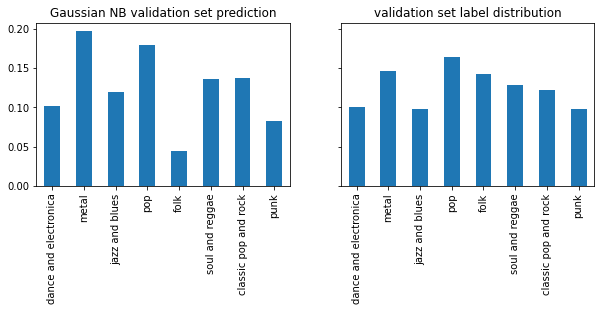

In [160]:
print(classification_report(valid_labels, preds, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(preds, columns=valid_labels.columns, index=valid_audio_normalized_low_corr_chi_selected.index), 
                                    valid_labels,
                                    title1="Gaussian NB validation set prediction")

### Find important words

In [166]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

lectures = (train_features.iloc[:,1]).values
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(lectures)
features_by_gram = defaultdict(list)
for f, w in zip(vectorizer.get_feature_names(), vectorizer.idf_):
    features_by_gram[len(f.split(' '))].append((f, w))
top_n = 2
for gram, features in features_by_gram.iteritems():
    top_features = sorted(features, key=lambda x: x[1], reverse=True)[:top_n]
    top_features = [f[0] for f in top_features]
    print ("{}-gram top:".format(gram), top_features)

AttributeError: 'collections.defaultdict' object has no attribute 'iteritems'

In [121]:
feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 100
top_n = feature_array[tfidf_sorting][:n]
top_n

array(['don', 'ur', 'll', 'qué', 'iâ', 'won', 'caus', 'fool', 'follow',
       'fond', 'fondo', 'font', 'food', 'über', 'foolish', 'foot', 'foi',
       'footstep', 'fora', 'forbidden', 'forc', 'fold', 'foe', 'fog',
       'flor', 'flip', 'flirt', 'float', 'flock', 'flood', 'floor',
       'flore', 'foreign', 'flow', 'flower', 'flown', 'flyin', 'fo',
       'focus', 'fore', 'forg', 'forest', 'forev', 'foul', 'foundat',
       'fountain', 'fr', 'fra', 'fragil', 'fragment', 'frame', 'franc',
       'frank', 'freak', 'free', 'freedom', 'freeway', 'freez', 'fought',
       'fou', 'foto', 'form', 'flicker', 'forget', 'forgiv', 'forgiven',
       'forgot', 'forgotten', 'forma', 'forward', 'forsak', 'forsaken',
       'fort', 'forth', 'forti', 'fortun', 'flight', 'flesh', 'fli',
       'fest', 'fell', 'fella', 'fellow', 'felt', 'femm', 'fenc', 'feu',
       'felicidad', 'fever', 'fi', 'fiction', 'fiddl', 'fiel', 'field',
       'feliz', 'feet', 'flew', 'fearless', 'favor', 'favorit'],
      d

In [122]:
train_tag_important = train_tag[top_n]
valid_tag_important = valid_tag[top_n]

                       precision    recall  f1-score   support

      soul and reggae       0.00      0.00      0.00        55
 classic pop and rock       0.24      0.09      0.13        45
                metal       0.00      0.00      0.00        64
                 folk       0.11      0.95      0.20        44
                  pop       0.38      0.09      0.15        66
dance and electronica       1.00      0.24      0.39        74
       jazz and blues       0.75      0.07      0.12        44
                 punk       0.20      0.02      0.03        58

             accuracy                           0.16       450
            macro avg       0.33      0.18      0.13       450
         weighted avg       0.35      0.16      0.13       450



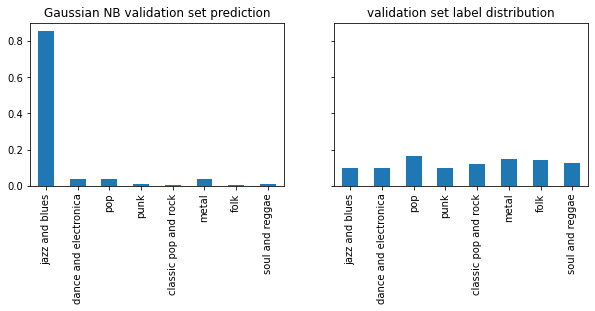

In [123]:
preds = gnb_train_predict(train_tag_important, train_labels['genre'], valid_tag_important, valid_labels['genre'])
print(classification_report(valid_labels, preds, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(preds, columns=valid_labels.columns, index=valid_audio_normalized_low_corr_chi_selected.index), 
                                    valid_labels,
                                    title1="Gaussian NB validation set prediction")

### add all meta and audio features

In [139]:
train_features_all = pd.concat([train_tag, train_features_num], axis=1, sort=False)
valid_features_all = pd.concat([valid_tag, valid_features_num], axis=1, sort=False)
test_features_all = pd.concat([test_tag, test_features_num], axis=1, sort=False)

                       precision    recall  f1-score   support

      soul and reggae       0.31      0.49      0.38        55
 classic pop and rock       0.64      0.20      0.31        45
                metal       0.68      0.23      0.35        64
                 folk       0.43      0.66      0.52        44
                  pop       0.84      0.85      0.84        66
dance and electronica       0.78      1.00      0.88        74
       jazz and blues       0.89      0.39      0.54        44
                 punk       0.65      0.88      0.75        58

             accuracy                           0.62       450
            macro avg       0.65      0.59      0.57       450
         weighted avg       0.66      0.62      0.59       450



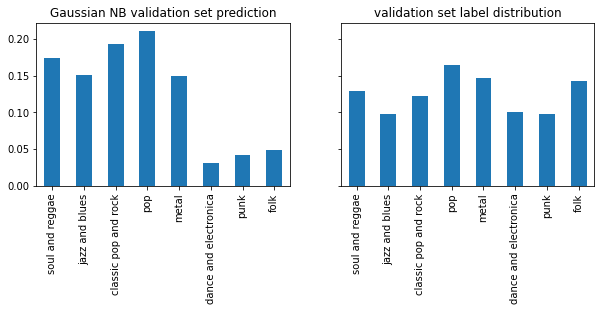

In [140]:
preds = gnb_train_predict(train_features_all, train_labels['genre'], valid_features_all, valid_labels['genre'])
print(classification_report(valid_labels, preds, target_names=valid_labels["genre"].unique()))
draw_train_valid_label_distribution(pd.DataFrame(preds, columns=valid_labels.columns, index=valid_audio_normalized_low_corr_chi_selected.index), 
                                    valid_labels,
                                    title1="Gaussian NB validation set prediction")

In [141]:
clf = GaussianNB()
gclf = clf.fit(train_features_all, train_labels)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [146]:
models = [gclf]
test_preds = predict(models, test_features_all)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

## compare

## test

In [ ]:
models = [trained_knn]
test_knn = select_df1_columns_based_on_df2(test_features, train_audio_normalized_low_corr_chi_selected)
test_knn = transform_continuous_0_1(test_knn)
test_preds = predict(models, test_knn)
test_preds[0].reset_index(level=0).to_csv(path_or_buf="test_pred.csv", columns=["trackID", "genre"], index=False)

In [ ]:
# Introduction to machine learning is fun!

# End